# **點追蹤+貪婪匹配範例**

## 下載套件與測試影像


In [ ]:
!wget https://motchallenge.net/sequenceVideos/MOT16-01-raw.mp4
%pip install ultralytics

## 建立多目標物件偵測器

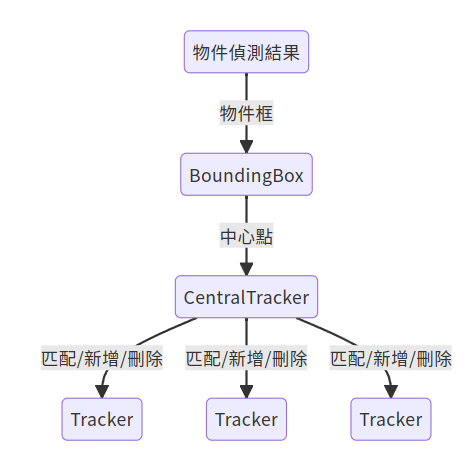

In [3]:
from scipy.spatial import distance
import random
class BoundingBox():
    def __init__(self, box):
        self.top_left = (box[0], box[1])
        self.bottom_right = (box[2], box[3])
        self.center = self.get_center()

    def get_center(self):
        center_x = (self.top_left[0] + self.bottom_right[0]) / 2
        center_y = (self.top_left[1] + self.bottom_right[1]) / 2
        return (center_x, center_y)

class Tracker():
    def __init__(self, bbox, tracker_id):
        self.bbox = bbox
        self.id = tracker_id
        self.history = [bbox.center]
        self.missed_frames = 0
        self.color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

    def update(self, bbox):
        self.bbox = bbox
        self.history.append(bbox.center)
        if len(self.history) > 30:
            self.history.pop(0)
        self.missed_frames = 0

class CentralTracker():
    def __init__(self):
        self.trackers = []
        self.next_id = 0

    def add_bounding_box(self, box):
        bbox = BoundingBox(box)
        tracker = Tracker(bbox, self.next_id)
        self.trackers.append(tracker)
        self.next_id += 1
        return tracker.id, bbox.center

    def update_trackers(self, new_boxes):
        new_boxes = [BoundingBox(box) for box in new_boxes]
        new_centers = [box.center for box in new_boxes]

        if not self.trackers:
            for box in new_boxes:
                self.add_bounding_box((box.top_left[0], box.top_left[1], box.bottom_right[0], box.bottom_right[1]))
        else:
            current_centers = [tracker.bbox.center for tracker in self.trackers]
            new_assigned = set()

            for tracker in self.trackers:
                min_dist = float('inf')
                min_idx = -1
                for j, center in enumerate(new_centers):
                    if j in new_assigned:
                        continue
                    dist = distance.euclidean(tracker.bbox.center, center)
                    #進行匹配，找到最近的點，若大於40像素，則視為不同的物體
                    if (dist < min_dist)and(dist<40):
                        min_dist = dist
                        min_idx = j
                if min_idx != -1:
                    tracker.update(new_boxes[min_idx])
                    new_assigned.add(min_idx)
                else:
                    tracker.missed_frames += 1

            # Add new trackers for unmatched new boxes
            for j, box in enumerate(new_boxes):
                if j not in new_assigned:
                    self.add_bounding_box((box.top_left[0], box.top_left[1], box.bottom_right[0], box.bottom_right[1]))

            # Remove trackers that have missed more than 5 frames
            self.trackers = [tracker for tracker in self.trackers if tracker.missed_frames <= 8]

    def get_all_centers(self):
        return [(tracker.id, tracker.bbox.center) for tracker in self.trackers]
    def get_tracker_histories(self):
        return {tracker.id: tracker.history for tracker in self.trackers}
    def get_color(self):
        return {tracker.id: tracker.color for tracker in self.trackers}


## 使用YOLOV8進行偵測，並使用偵測結果進行追蹤

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
# Load a model
model = YOLO("yolov8n.pt")  # pretrained YOLOv8n model
cap = cv2.VideoCapture('./MOT16-01-raw.mp4')
tracker = CentralTracker()
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640,480))
# Run batched inference on a list of images
while True:
    ret,img = cap.read()
    if not ret:
        break
    result = model([img])[0]
# Process results list
    datas = np.asarray(result.boxes.data)
    datas = datas[np.where(datas[:,-1]==0)]
# 物件追蹤
    tracker.update_trackers(datas)
# 獲取追蹤結果，並畫在圖像中
    trackerlines = tracker.get_tracker_histories()
    colors = tracker.get_color()
    for trackid in trackerlines:
        trackerline = trackerlines[trackid]
        color = colors[trackid]
        pass_point = []
        for trackpoint in trackerline:
            new_point = np.array(trackpoint,dtype=np.int64)
            cv2.circle(img,new_point,3,color,-1)
            if len(pass_point)!=0:
                cv2.line(img,pass_point,new_point,color,3)
            pass_point = new_point
    out.write(cv2.resize(img,(640,480)))


